# Signal Collinearity Analysis

Analyze the collinearity between the PCR signal (`index_russell_pcr_signal_old_universe`) and the
futures-only baseline signal (`futures_only_signal`).

Both signals are minute-level, partitioned by ticker. The analysis uses the overlapping date range
and focuses on entry times used in backtesting.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import spearmanr, pearsonr
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

DATA_DIR = Path('..') / 'data'
PCR_SIGNAL_DIR = DATA_DIR / 'processed' / 'index_russell_pcr_signal_old_universe'
FUTURES_SIGNAL_DIR = DATA_DIR / 'processed' / 'futures_only_signal'
ENTRY_TIMES = ['13:00', '13:30', '14:00', '14:30', '15:00', '15:30']

## Load metadata

In [2]:
adr_info = pd.read_csv(DATA_DIR / 'raw' / 'adr_info.csv')
adr_info['ticker'] = adr_info['adr'].str.replace(' US Equity', '')
all_tickers = sorted(adr_info['ticker'].tolist())

# Tickers present in both signal dirs
pcr_tickers = {p.name.replace('ticker=', '') for p in PCR_SIGNAL_DIR.iterdir()}
fut_tickers = {p.name.replace('ticker=', '') for p in FUTURES_SIGNAL_DIR.iterdir()}
common_tickers = sorted(pcr_tickers & fut_tickers)
print(f'{len(common_tickers)} tickers in both signal dirs')

54 tickers in both signal dirs


## Load signals

In [3]:
def load_signals(signal_dir, tickers):
    """Load signal parquets, return dict: ticker -> DataFrame(DatetimeIndex, signal, date)."""
    signals = {}
    for ticker in tickers:
        path = signal_dir / f'ticker={ticker}' / 'data.parquet'
        if path.exists():
            signals[ticker] = pd.read_parquet(path)
    return signals


print('Loading PCR signals...')
pcr_signals = load_signals(PCR_SIGNAL_DIR, common_tickers)
print(f'  Loaded {len(pcr_signals)} tickers')

print('Loading futures-only signals...')
fut_signals = load_signals(FUTURES_SIGNAL_DIR, common_tickers)
print(f'  Loaded {len(fut_signals)} tickers')

# Date range overlap
pcr_min = min(df.index.min() for df in pcr_signals.values())
pcr_max = max(df.index.max() for df in pcr_signals.values())
fut_min = min(df.index.min() for df in fut_signals.values())
fut_max = max(df.index.max() for df in fut_signals.values())
print(f'\nPCR signal range: {pcr_min} to {pcr_max}')
print(f'Futures signal range: {fut_min} to {fut_max}')

Loading PCR signals...
  Loaded 54 tickers
Loading futures-only signals...
  Loaded 54 tickers

PCR signal range: 2025-09-02 09:35:00-04:00 to 2026-01-30 16:00:00-05:00
Futures signal range: 2018-08-23 09:30:00-04:00 to 2026-02-13 16:00:00-05:00


## Align signals on overlapping timestamps

In [4]:
# Build aligned DataFrames per ticker on the overlapping index
aligned = {}  # ticker -> DataFrame with columns 'pcr', 'futures', 'date'
for ticker in common_tickers:
    pcr_df = pcr_signals[ticker]
    fut_df = fut_signals[ticker]
    common_idx = pcr_df.index.intersection(fut_df.index)
    if len(common_idx) == 0:
        continue
    df = pd.DataFrame({
        'pcr': pcr_df.loc[common_idx, 'signal'].values,
        'futures': fut_df.loc[common_idx, 'signal'].values,
    }, index=common_idx)
    df['date'] = pcr_df.loc[common_idx, 'date'].values
    aligned[ticker] = df

print(f'{len(aligned)} tickers with overlapping data')
total_obs = sum(len(df) for df in aligned.values())
print(f'{total_obs:,} total aligned minute observations')
sample_ticker = common_tickers[0]
print(f'\nSample ({sample_ticker}):')
aligned[sample_ticker].head()

54 tickers with overlapping data
1,430,076 total aligned minute observations

Sample (AEG):


,pcr,futures,date
2025-09-02 11:31:00-04:00,0.004784,0.005185,2025-09-02
2025-09-02 11:32:00-04:00,0.002995,0.003396,2025-09-02
2025-09-02 11:33:00-04:00,0.002151,0.002552,2025-09-02
2025-09-02 11:34:00-04:00,0.002288,0.002690,2025-09-02
2025-09-02 11:35:00-04:00,-0.000098,0.000304,2025-09-02


## Per-ticker correlation (all overlapping minutes)

In [5]:
per_ticker_corr = []
for ticker, df in aligned.items():
    valid = df[['pcr', 'futures']].dropna()
    if len(valid) < 30:
        continue
    r_pearson, _ = pearsonr(valid['pcr'], valid['futures'])
    r_spearman, _ = spearmanr(valid['pcr'], valid['futures'])
    per_ticker_corr.append({
        'ticker': ticker,
        'pearson': r_pearson,
        'spearman': r_spearman,
        'n_obs': len(valid),
        'pcr_std': valid['pcr'].std(),
        'futures_std': valid['futures'].std(),
        'diff_std': (valid['pcr'] - valid['futures']).std(),
    })

corr_df = pd.DataFrame(per_ticker_corr).set_index('ticker').sort_values('pearson')
print('Per-ticker signal correlation (all overlapping minutes)')
print('=' * 75)
display(corr_df.round(4))
print(f'\nMean Pearson: {corr_df["pearson"].mean():.4f}')
print(f'Mean Spearman: {corr_df["spearman"].mean():.4f}')

Per-ticker signal correlation (all overlapping minutes)


,pearson,spearman,n_obs,pcr_std,futures_std,diff_std
ticker,,,,,,
UBS,0.9511,0.9362,24182,0.0025,0.0023,0.0008
PSO,0.9738,0.9637,25336,0.0020,0.0020,0.0005
NVS,0.9746,0.9560,24182,0.0035,0.0034,0.0008
ERIC,0.9777,0.9621,23913,0.0036,0.0036,0.0008
NVO,0.9784,0.9595,27313,0.0080,0.0079,0.0017
GMAB,0.9801,0.9776,27313,0.0077,0.0075,0.0015
DB,0.9858,0.9802,25573,0.0027,0.0025,0.0005
EQNR,0.9928,0.9883,30992,0.0070,0.0068,0.0009
PHG,0.9930,0.9919,25842,0.0026,0.0026,0.0003



Mean Pearson: 0.9954
Mean Spearman: 0.9930


## Correlation by entry time

Extract signals at each fixed entry time and compute correlations.

In [6]:
def extract_at_time(aligned_dict, entry_time):
    """Extract signal values at a specific time for all tickers.
    Returns DataFrame with columns: ticker, date, pcr, futures."""
    h, m = map(int, entry_time.split(':'))
    parts = []
    for ticker, df in aligned_dict.items():
        mask = (df.index.hour == h) & (df.index.minute == m)
        sub = df.loc[mask]
        if len(sub) == 0:
            continue
        part = sub[['date', 'pcr', 'futures']].copy()
        part['ticker'] = ticker
        parts.append(part)
    if not parts:
        return pd.DataFrame(columns=['ticker', 'date', 'pcr', 'futures'])
    result = pd.concat(parts, ignore_index=True)
    result['pcr'] = result['pcr'].astype(np.float64)
    result['futures'] = result['futures'].astype(np.float64)
    return result


time_corrs = []
for entry_time in ENTRY_TIMES:
    et_df = extract_at_time(aligned, entry_time).dropna(subset=['pcr', 'futures'])
    if len(et_df) < 30:
        continue
    # Pooled correlation
    r_pool, _ = pearsonr(et_df['pcr'], et_df['futures'])
    rho_pool, _ = spearmanr(et_df['pcr'], et_df['futures'])
    # R-squared
    r2 = r_pool ** 2
    # Mean absolute difference
    mad = (et_df['pcr'] - et_df['futures']).abs().mean()
    time_corrs.append({
        'entry_time': entry_time,
        'pearson': r_pool,
        'spearman': rho_pool,
        'R2': r2,
        'mean_abs_diff': mad,
        'n_obs': len(et_df),
    })

time_corr_df = pd.DataFrame(time_corrs).set_index('entry_time')
print('Pooled signal correlation by entry time')
print('=' * 65)
display(time_corr_df.round(4))

Pooled signal correlation by entry time


,pearson,spearman,R2,mean_abs_diff,n_obs
entry_time,,,,,
13:00,0.9947,0.9880,0.9893,0.0003,4945
13:30,0.9948,0.9887,0.9896,0.0003,4938
14:00,0.9950,0.9900,0.9899,0.0003,4938
14:30,0.9950,0.9901,0.9901,0.0003,4932
15:00,0.9949,0.9908,0.9899,0.0003,4926
15:30,0.9961,0.9928,0.9922,0.0003,4920


## Per-ticker correlation at 14:00 entry

In [7]:
main_time = '14:00'
et_df = extract_at_time(aligned, main_time)

ticker_time_corrs = []
for ticker in common_tickers:
    sub = et_df[et_df['ticker'] == ticker].dropna(subset=['pcr', 'futures'])
    if len(sub) < 20:
        continue
    r, _ = pearsonr(sub['pcr'], sub['futures'])
    rho, _ = spearmanr(sub['pcr'], sub['futures'])
    r2 = r ** 2
    diff = sub['pcr'] - sub['futures']
    ticker_time_corrs.append({
        'ticker': ticker,
        'pearson': r,
        'spearman': rho,
        'R2': r2,
        'mean_diff': diff.mean(),
        'std_diff': diff.std(),
        'n_obs': len(sub),
    })

ticker_corr_at_time = pd.DataFrame(ticker_time_corrs).set_index('ticker').sort_values('pearson')
print(f'Per-ticker correlation at {main_time} entry')
print('=' * 75)
display(ticker_corr_at_time.round(4))

Per-ticker correlation at 14:00 entry


,pearson,spearman,R2,mean_diff,std_diff,n_obs
ticker,,,,,,
UBS,0.9295,0.9413,0.8639,-0.0003,0.0010,91
ERIC,0.9620,0.9413,0.9254,-0.0001,0.0010,90
NVS,0.9740,0.9544,0.9487,0.0001,0.0008,91
PSO,0.9759,0.9692,0.9524,0.0000,0.0004,94
NVO,0.9781,0.9479,0.9566,0.0005,0.0018,92
DB,0.9892,0.9859,0.9785,-0.0002,0.0005,95
GMAB,0.9903,0.9745,0.9806,-0.0000,0.0014,92
PHG,0.9937,0.9907,0.9875,0.0001,0.0003,96
EQNR,0.9953,0.9920,0.9906,-0.0004,0.0008,92


## Daily rolling correlation

For each day, pool all tickers' signals at the main entry time and compute the cross-sectional correlation.
Then plot the rolling mean to see if collinearity varies over time.

In [8]:
et_df = extract_at_time(aligned, main_time)
daily_corrs = []
min_tickers = 5
for date, group in et_df.groupby('date'):
    valid = group.dropna(subset=['pcr', 'futures'])
    if len(valid) < min_tickers:
        continue
    r, _ = pearsonr(valid['pcr'], valid['futures'])
    daily_corrs.append({'date': pd.Timestamp(date), 'pearson': r, 'n_tickers': len(valid)})

daily_corr_df = pd.DataFrame(daily_corrs).set_index('date').sort_index()
print(f'{len(daily_corr_df)} days with >= {min_tickers} tickers at {main_time}')
print(f'Mean daily cross-sectional Pearson: {daily_corr_df["pearson"].mean():.4f}')
print(f'Median: {daily_corr_df["pearson"].median():.4f}')
print(f'Std: {daily_corr_df["pearson"].std():.4f}')

101 days with >= 5 tickers at 14:00
Mean daily cross-sectional Pearson: 0.9934
Median: 0.9955
Std: 0.0088


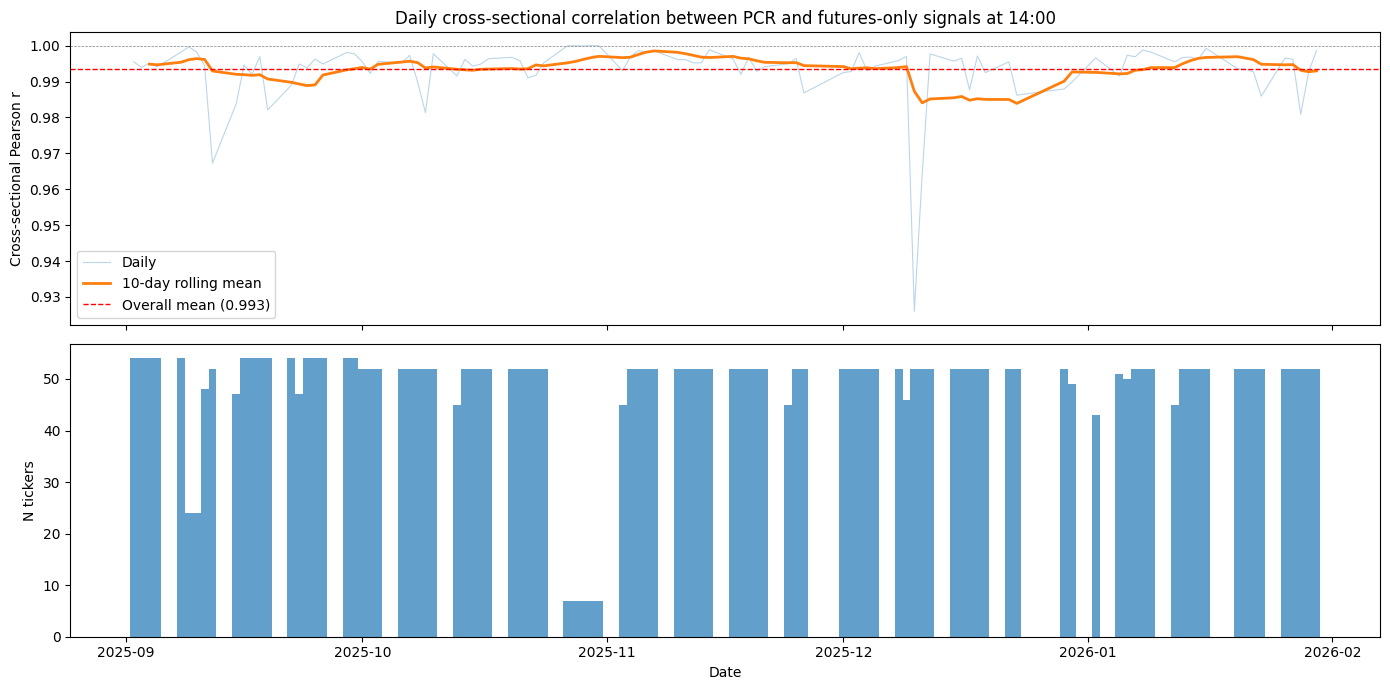

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

ax = axes[0]
ax.plot(daily_corr_df.index, daily_corr_df['pearson'], alpha=0.3, linewidth=0.8, label='Daily')
rolling_window = 10
rolling_corr = daily_corr_df['pearson'].rolling(rolling_window, min_periods=3).mean()
ax.plot(daily_corr_df.index, rolling_corr, linewidth=2, label=f'{rolling_window}-day rolling mean')
ax.axhline(1.0, color='gray', linewidth=0.5, linestyle='--')
ax.axhline(daily_corr_df['pearson'].mean(), color='red', linewidth=1, linestyle='--',
           label=f'Overall mean ({daily_corr_df["pearson"].mean():.3f})')
ax.set_ylabel('Cross-sectional Pearson r')
ax.set_title(f'Daily cross-sectional correlation between PCR and futures-only signals at {main_time}')
ax.legend()

ax = axes[1]
ax.bar(daily_corr_df.index, daily_corr_df['n_tickers'], width=1, alpha=0.7)
ax.set_ylabel('N tickers')
ax.set_xlabel('Date')

plt.tight_layout()  
plt.show()

## Signal difference analysis

The PCR signal = futures-only signal + Russell stock adjustment. Analyze the "increment" that PCR adds.

In [10]:
et_df = extract_at_time(aligned, main_time)
et_df['diff'] = et_df['pcr'] - et_df['futures']
et_df['abs_diff'] = et_df['diff'].abs()

# How often does the PCR signal actually differ?
n_same = (et_df['diff'] == 0).sum()
n_total = len(et_df)
print(f'At {main_time}:')
print(f'  Observations where PCR == futures: {n_same}/{n_total} ({100*n_same/n_total:.1f}%)')
print(f'  Observations where PCR != futures: {n_total - n_same}/{n_total} ({100*(n_total-n_same)/n_total:.1f}%)')

# Per ticker
diff_summary = []
for ticker in common_tickers:
    sub = et_df[et_df['ticker'] == ticker]
    if len(sub) == 0:
        continue
    n_diff = (sub['diff'] != 0).sum()
    diff_summary.append({
        'ticker': ticker,
        'n_total': len(sub),
        'n_differ': n_diff,
        'pct_differ': 100 * n_diff / len(sub),
        'mean_abs_diff': sub['abs_diff'].mean(),
        'max_abs_diff': sub['abs_diff'].max(),
        'diff_as_pct_of_futures_std': sub['diff'].std() / sub['futures'].std() if sub['futures'].std() > 0 else np.nan,
    })

diff_df = pd.DataFrame(diff_summary).set_index('ticker').sort_values('mean_abs_diff', ascending=False)
print(f'\nSignal difference summary at {main_time}')
print('=' * 85)
display(diff_df.round(4))

At 14:00:
  Observations where PCR == futures: 0/4955 (0.0%)
  Observations where PCR != futures: 4955/4955 (100.0%)

Signal difference summary at 14:00


,n_total,n_differ,pct_differ,mean_abs_diff,max_abs_diff,diff_as_pct_of_futures_std
ticker,,,,,,
NVO,92,92,100.0,0.0014,0.0064,0.2132
ARGX,96,96,100.0,0.0011,0.0024,0.0683
GMAB,92,92,100.0,0.0009,0.0081,0.1418
GSK,94,94,100.0,0.0008,0.0012,0.0346
EQNR,92,92,100.0,0.0007,0.0038,0.1001
ERIC,91,91,100.0,0.0007,0.0058,0.2764
UBS,91,91,100.0,0.0006,0.0069,0.4107
NVS,91,91,100.0,0.0006,0.0030,0.2320
BCS,94,94,100.0,0.0006,0.0009,0.0606


## Scatter plots: PCR vs futures-only signal

Select tickers with highest and lowest collinearity for visual inspection.

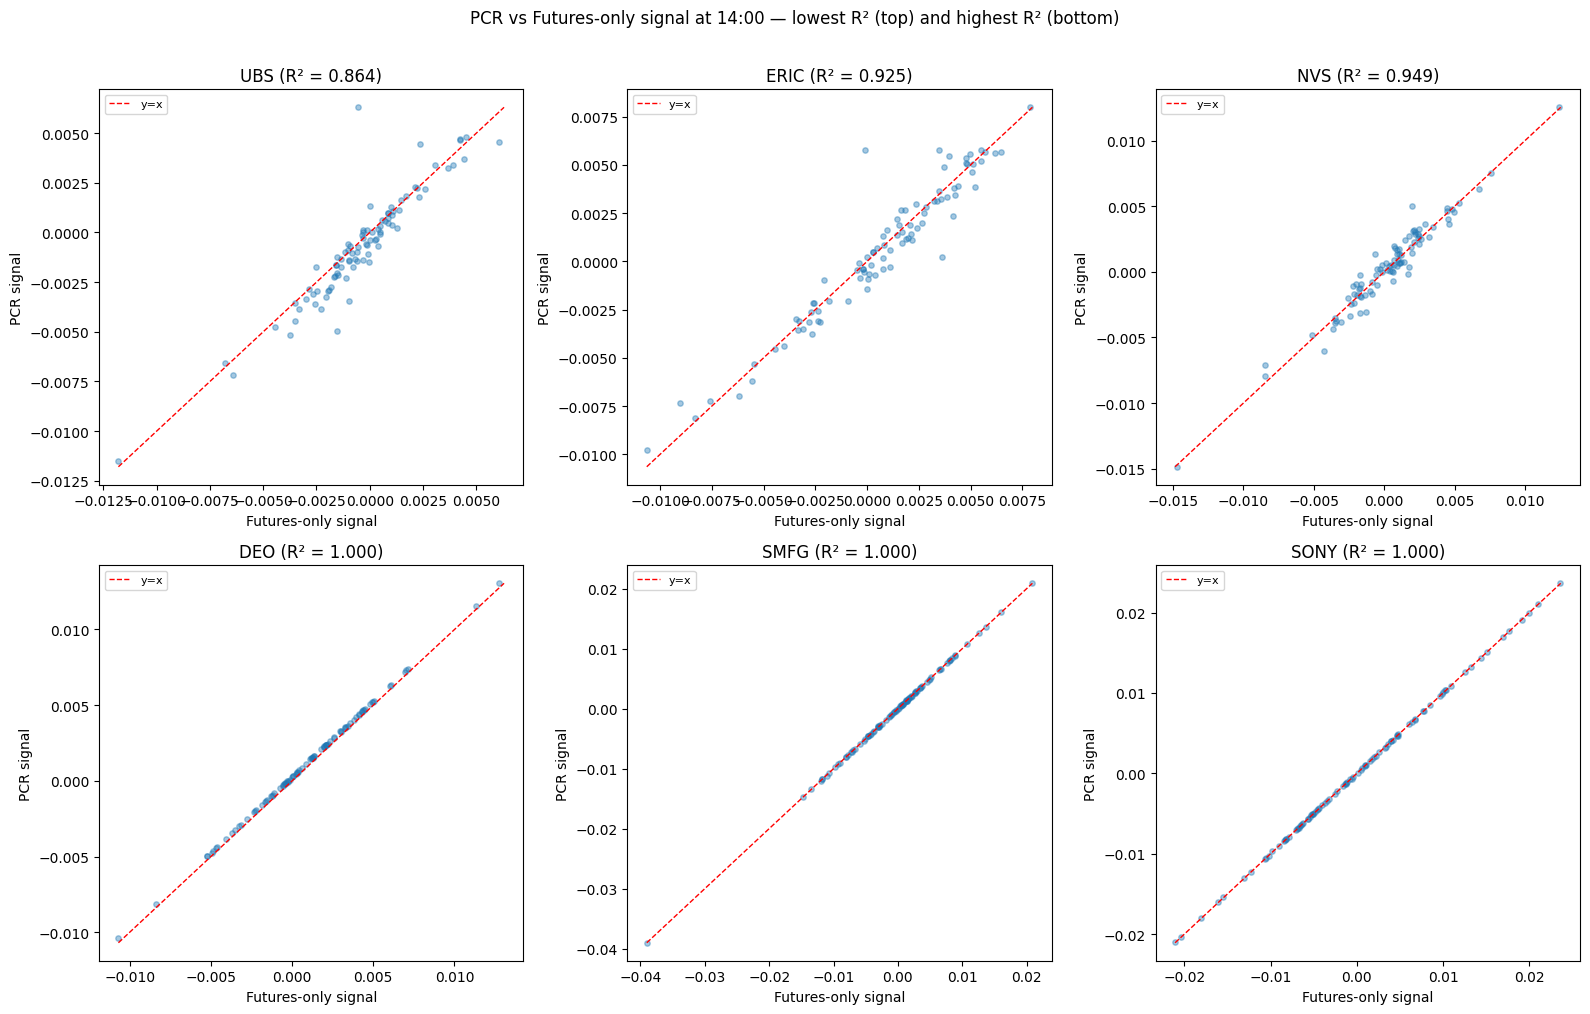

In [11]:
# Pick 6 tickers: 3 with lowest R2, 3 with highest R2 at main_time
r2_sorted = ticker_corr_at_time['R2'].sort_values()
show_tickers = list(r2_sorted.head(3).index) + list(r2_sorted.tail(3).index)

et_df = extract_at_time(aligned, main_time)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for ax, ticker in zip(axes.flat, show_tickers):
    sub = et_df[et_df['ticker'] == ticker].dropna(subset=['pcr', 'futures'])
    ax.scatter(sub['futures'], sub['pcr'], alpha=0.4, s=15)
    # 45-degree line
    lims = [min(sub['futures'].min(), sub['pcr'].min()),
            max(sub['futures'].max(), sub['pcr'].max())]
    ax.plot(lims, lims, 'r--', linewidth=1, label='y=x')
    r2 = ticker_corr_at_time.loc[ticker, 'R2']
    ax.set_title(f'{ticker} (R² = {r2:.3f})')
    ax.set_xlabel('Futures-only signal')
    ax.set_ylabel('PCR signal')
    ax.legend(fontsize=8)

plt.suptitle(f'PCR vs Futures-only signal at {main_time} — lowest R² (top) and highest R² (bottom)', y=1.01)
plt.tight_layout()
plt.show()

## Distribution of signal differences

/tmp/ipykernel_1151094/202083415.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=box_labels, vert=True)


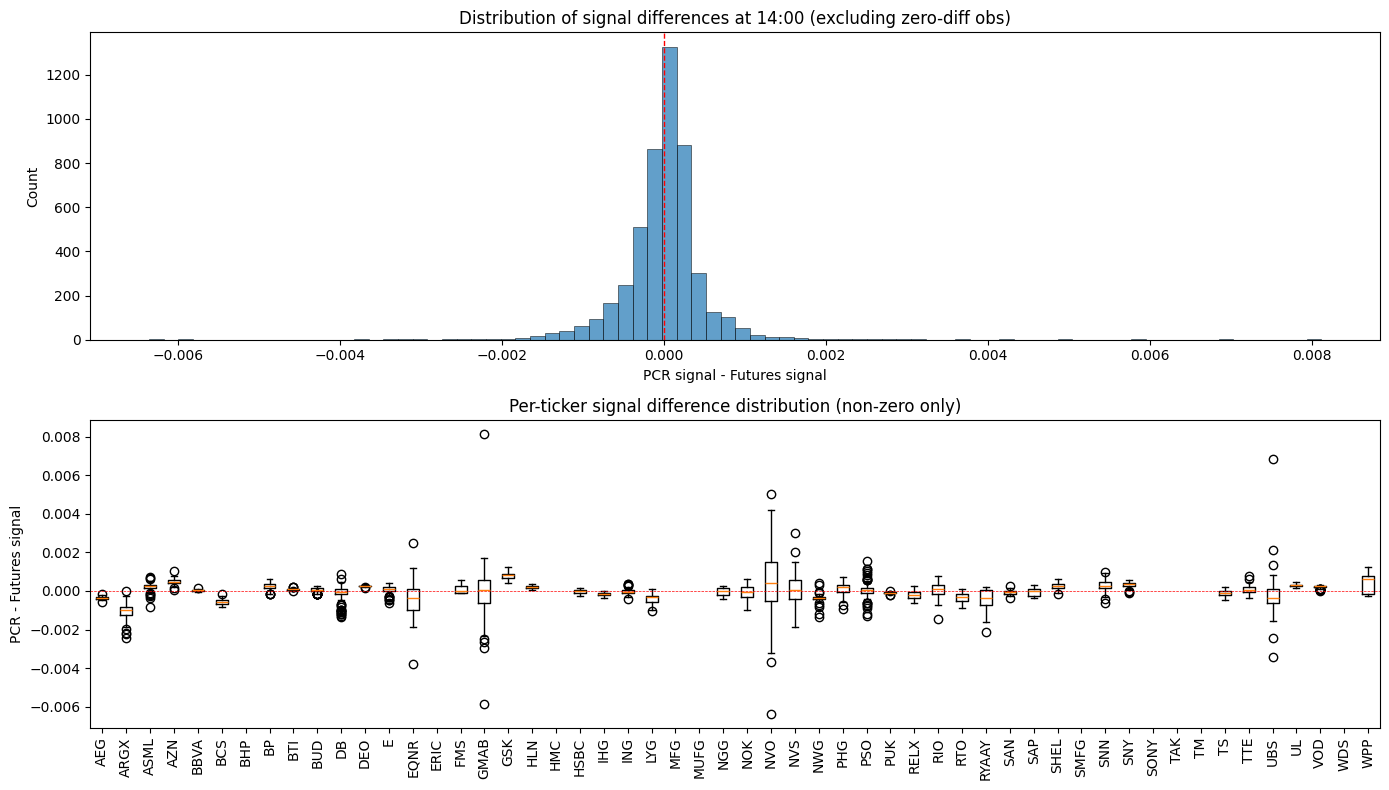

In [12]:
et_df = extract_at_time(aligned, main_time)
et_df['diff'] = et_df['pcr'] - et_df['futures']

# Only tickers where signals actually differ
differ_tickers = diff_df[diff_df['n_differ'] > 0].index.tolist()

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Overall histogram
ax = axes[0]
diffs_nonzero = et_df.loc[et_df['diff'] != 0, 'diff']
ax.hist(diffs_nonzero, bins=80, alpha=0.7, edgecolor='black', linewidth=0.5)
ax.axvline(0, color='red', linewidth=1, linestyle='--')
ax.set_xlabel('PCR signal - Futures signal')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of signal differences at {main_time} (excluding zero-diff obs)')

# Per-ticker boxplot
ax = axes[1]
box_data = []
box_labels = []
for ticker in sorted(differ_tickers):
    sub = et_df[(et_df['ticker'] == ticker) & (et_df['diff'] != 0)]['diff']
    if len(sub) > 0:
        box_data.append(sub.values)
        box_labels.append(ticker)

if box_data:
    ax.boxplot(box_data, labels=box_labels, vert=True)
    ax.set_xticklabels(box_labels, rotation=90)
    ax.axhline(0, color='red', linewidth=0.5, linestyle='--')
    ax.set_ylabel('PCR - Futures signal')
    ax.set_title('Per-ticker signal difference distribution (non-zero only)')

plt.tight_layout()
plt.show()

## Variance decomposition

For each ticker, decompose the PCR signal variance into:
- Variance explained by the futures-only signal (R²)
- Residual variance (the PCR "increment")

In [ ]:
var_decomp = []
for ticker in common_tickers:
    if ticker not in aligned:
        continue
    df = aligned[ticker][['pcr', 'futures']].dropna()
    if len(df) < 30:
        continue
    var_pcr = df['pcr'].var()
    var_fut = df['futures'].var()
    var_diff = (df['pcr'] - df['futures']).var()
    cov = df[['pcr', 'futures']].cov().iloc[0, 1]
    r2 = pearsonr(df['pcr'], df['futures'])[0] ** 2
    var_decomp.append({
        'ticker': ticker,
        'var_pcr': var_pcr,
        'var_futures': var_fut,
        'var_diff': var_diff,
        'covariance': cov,
        'R2': r2,
        'pct_variance_from_futures': 100 * r2,
        'pct_new_variance': 100 * (1 - r2),
    })

var_df = pd.DataFrame(var_decomp).set_index('ticker').sort_values('R2', ascending=False)
print('Variance decomposition (all overlapping minutes)')
print('=' * 90)
display(var_df.round(4))

print(f'\nMean R²: {var_df["R2"].mean():.4f}')
print(f'Median R²: {var_df["R2"].median():.4f}')
print(f'Mean % new variance from PCR: {var_df["pct_new_variance"].mean():.1f}%')

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))

tickers_sorted = var_df.index.tolist()
x = range(len(tickers_sorted))
ax.bar(x, var_df['pct_variance_from_futures'], label='Explained by futures (R² %)', color='steelblue')
ax.bar(x, var_df['pct_new_variance'], bottom=var_df['pct_variance_from_futures'],
       label='New variance from PCR (%)', color='coral')
ax.set_xticks(x)
ax.set_xticklabels(tickers_sorted, rotation=90)
ax.set_ylabel('% of PCR signal variance')
ax.set_title('Variance decomposition: how much of PCR signal is explained by futures-only signal')
ax.legend()
ax.set_ylim(0, 105)

plt.tight_layout()
plt.show()

## Correlation between signal differences across tickers

Check if the PCR increments (PCR - futures) are correlated across tickers, which would indicate
a common factor driving the difference.

In [ ]:
# Build a wide DataFrame of signal differences at the main entry time
et_df = extract_at_time(aligned, main_time)
et_df['diff'] = et_df['pcr'] - et_df['futures']

# Pivot to wide: date x ticker
diff_wide = et_df.pivot(index='date', columns='ticker', values='diff')
# Only keep tickers that actually have non-zero differences
nonzero_cols = [c for c in diff_wide.columns if (diff_wide[c] != 0).any()]
diff_wide = diff_wide[nonzero_cols].dropna(how='all')

if len(nonzero_cols) > 1:
    diff_corr = diff_wide.corr()

    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(diff_corr.values, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    ax.set_xticks(range(len(diff_corr.columns)))
    ax.set_yticks(range(len(diff_corr.columns)))
    ax.set_xticklabels(diff_corr.columns, rotation=90)
    ax.set_yticklabels(diff_corr.columns)
    ax.set_title(f'Correlation of PCR increments (PCR - futures) across tickers at {main_time}')
    plt.colorbar(im, ax=ax, shrink=0.8)
    plt.tight_layout()
    plt.show()

    # Summary stats on off-diagonal correlations
    mask = np.ones(diff_corr.shape, dtype=bool)
    np.fill_diagonal(mask, False)
    off_diag = diff_corr.values[mask]
    print(f'Off-diagonal increment correlations:')
    print(f'  Mean: {off_diag.mean():.4f}')
    print(f'  Median: {np.median(off_diag):.4f}')
    print(f'  Std: {off_diag.std():.4f}')
    print(f'  Min: {off_diag.min():.4f}, Max: {off_diag.max():.4f}')
else:
    print('Not enough tickers with non-zero differences for cross-ticker analysis')

## Summary

In [ ]:
print('Signal Collinearity Summary')
print('=' * 60)
print(f'Tickers analyzed: {len(aligned)}')
print(f'Overlapping date range: {pcr_min.date()} to {pcr_max.date()}')
print(f'\nOverall (all minutes):')
print(f'  Mean per-ticker Pearson r: {corr_df["pearson"].mean():.4f}')
print(f'  Mean per-ticker R²:        {var_df["R2"].mean():.4f}')
print(f'  Mean new variance from PCR: {var_df["pct_new_variance"].mean():.1f}%')
print(f'\nAt {main_time} entry:')
print(f'  Pooled Pearson r:  {time_corr_df.loc[main_time, "pearson"]:.4f}')
print(f'  Pooled R²:         {time_corr_df.loc[main_time, "R2"]:.4f}')

n_same_total = diff_df['n_total'].sum() - diff_df['n_differ'].sum()
n_all = diff_df['n_total'].sum()
print(f'\n  Obs where signals are identical: {n_same_total}/{n_all} ({100*n_same_total/n_all:.1f}%)')
print(f'  Obs where signals differ:        {n_all - n_same_total}/{n_all} ({100*(n_all - n_same_total)/n_all:.1f}%)')